<a href="https://colab.research.google.com/github/salama4ai/AI-project/blob/main/PyTorch_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is for preprocessing the data and implementing the model using Pytorch library

In [1]:
# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

In [2]:
# this line to select the GPU as an engine for doing the work if it's possible, else it selects the 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=7
set_random_seed(seed=seed)

In [3]:
# read the csv data file
x = pd.read_csv("/content/drive/MyDrive/Mabrains-project/Mabrains-data/mabrains.csv")

In [4]:
# show the first 5 rows
x.head()

,vds,L(um),W(um),vgs,vsb,corner,id(uA)
0,-0.45,8.0,0.84,0.0,0.0,tt,0.034866
1,-0.40,8.0,0.84,0.0,0.0,tt,0.009451
2,-0.35,8.0,0.84,0.0,0.0,tt,0.002331
3,-0.30,8.0,0.84,0.0,0.0,tt,0.000532
4,-0.25,8.0,0.84,0.0,0.0,tt,0.000111


# Preprocessing & Feature-Engineering

1- i will convert corner column into one hot encoded columns

2-i will convert the 2 columns 'W(um)' and L(um) into one column by dividing W/L as stated in the equation, that for 2 reasons,
- firstly to reduce number of columns without losing them contained information,
- and secondly as that is exactly how the equation used these 2 variables

- i will also apply on W/L resulting column minmaxscaler method, to make sure that the high values in this column will not dominate the model calculations and thus the model decision just due to containing high values

- also as i showed in the EDA note book that 'Temperature' and 'drain_length(um)' columns can be deleted safely as each of them contains only a single unique repeated value, thus the entropy in each of them are zero and the information that they will contripute to the model are also zeros, so removing them will not represent any losing, yet by including them in the model we increase curse-of-dimentionality and make it's harded for the model to extract the underlying knowledge from the other columns.

In [5]:
# lets convert the 2 columns 'W(um)' and L(um) into one column by dividing W/L as stated in the equation, that for 2 reasons, one to reduce
# number of columns without losing them contained information, and secondly as that is exactly how the equation used these 2 variables
x['W/L'] = x['W(um)']/x['L(um)']
x['W/L'].value_counts()

4.333333      67705
46.666667     67705
2.000000      67705
14.000000     67705
1.300000      67705
166.666667    67705
0.720000      67705
1.680000      67705
6.666667      67705
5.600000      67705
2.400000      67705
6.266667      67705
1.880000      54712
50.000000      2008
0.105000       1398
0.081250        910
Name: W/L, dtype: int64

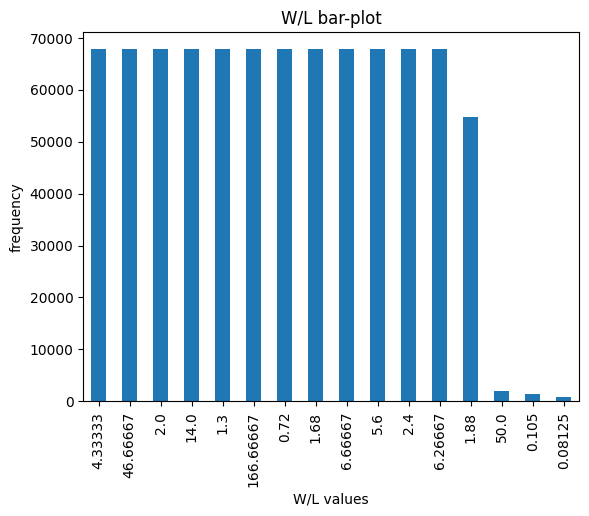

In [6]:
# plot the values and value counts of 'W/L' column
x['W/L'].round(5).value_counts().plot(kind='bar', title='W/L bar-plot')
plt.xlabel('W/L values')
plt.ylabel('frequency')
plt.show()

In [7]:
# separate the output(or label or target) column from the features(input) columns
# where 'x' the feature columns,
# and 'y' is the target column
y = x.pop("id(uA)")

# split the train and test sets and the coresponding labels
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(x, y, test_size=0.21, random_state=seed, shuffle=True)

In [8]:
# apply the needed transformations over the determined columns
col_trans1 = make_column_transformer(("passthrough", ['vgs', 'vds', 'vsb']),
                                    (OneHotEncoder(handle_unknown="infrequent_if_exist"), ['corner']),
                                    (MinMaxScaler(), ['W/L']),
                                     remainder="drop",
                                     n_jobs=-1)

# apply the needed transformations over the training data
xtrain = col_trans1.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = col_trans1.transform(xtest_unprocessed)

In [9]:
class CollectedData(Dataset):
    '''create the class to deal with the data convert them into torch tensors, getting the data item and getting the length of the data'''

    def __init__(self, x, y):
        self.data = torch.tensor(x)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]


    def __getitem__(self, idx):
        '''return the data sample given the index'''

        # return the features and the corresponding label of the given index
        # i convert them to float to solve an error appears while train the model
        return self.data[idx].float(), self.label[idx].float()

    def __len__(self):
        '''function to return the length of the dataset'''

        # return the length of the dataset
        return self.n_smpl

#compine the features and the corresponding labels into one object
train_set = CollectedData(xtrain, ytrain)

#compine the features and the corresponding labels into one object
test_set = CollectedData(xtest, ytest)

In [10]:
## almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels = torch.tensor(ytrain.values.astype(np.float32))
# # test_labels = torch.tensor(ytest.values.astype(np.float32)) #i can do this step now, but i will delay doing this step, to collect all test data preprocessing in one cell
# train_input = torch.tensor(xtrain.values.astype(np.float32))
# # test_input = torch.tensor(xtest.values.astype(np.float32)) #i can do this step now, but i will delay doing this step, to collect all test data preprocessing in one cell

# train_set = TensorDataset(train_input, train_labels)
# # test_set = TensorDataset(test_input, test_labels)


In [16]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader):
    '''this function is to calculate the loss or the error between the true(correct) labels and the predicted labels'''

    # Set the model to eval mode while validating
    model.eval()

    # initialize error to zero
    error = 0
    num_samples = 0

    # starting the loop over data
    for data, labels in data_loader:

        # transfering data to cuda
        data = data.to(device=device)

        # transfering labels to cuda
        labels = labels.to(device=device)

        # get the model predictions of the given data
        preds = model(data)

        # increase number of samples by the new tested samples
        num_samples += len(labels)

        # increase the error by the new error of the tested samples
        error += r2_score(labels, preds)

    # return the model to the train mode.
    model.train()

    # return the result
    return error

In [17]:
class network(nn.Module):
    '''create the structure of the model'''

    def __init__(self, in_features=9, out_features=1):
        '''like a class constructor function or initialization'''

        super().__init__()
        # the fully connected layers
        self.fc1 = nn.Linear(in_features, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, out_features)

        # initialize the model parameters(weights, bias)
        self.initialize_weights()


    def forward(self, inpt):
        '''this the the forward path of the model'''

        # relu activation function over the output of the fully connected layed output
        out = F.relu(self.fc1(inpt))

        # leaky_relu activation function over the output of the fully connected layed output
        out = F.leaky_relu(self.fc2(out))

        # out = F.leaky_relu(self.fc3(out))
        # out = F.leaky_relu(self.fc4(out))
        # out = F.leaky_relu(self.fc5(out))
        out = ((self.fc6(out)))
        # out = F.softmax((self.fc6(out)), dim=1)

        # return the result
        return out

    def initialize_weights(self):
        '''initialize the model parameters(W, b)'''

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

# print the model structure
print(model)

network(
  (fc1): Linear(in_features=9, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
)


In [18]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

#the Learning Rate hyperparameter
lr = 0.5

# loss initializing
criterion = nn.MSELoss()

#optimizer initializing
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1-(1e-15), patience=9e99, verbose=True)

# determine number of calculations
num_epochs = 3

# set the batch size
batch_size = 4096

#
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

#
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

In [19]:
# define the training function.
def train_model(num_epochs, data_loader=train_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # starting training loop epochs
    result_train_acc, result_test_acc = [], []

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (data, labels) in progress:

            # convert data to device
            data = data.to(device=device)

            # convert labels to device
            labels = labels.to(device=device)

            # calculate the predictions.
            preds = model(data)

            # calculate the loss.
            loss = criterion(preds, labels)

            # back propagation calculations
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        # calculate the training accuracy
        train_acc = calculate_accuracy(model, data_loader=train_loader)

        # calculate the test accuracy
        test_acc = calculate_accuracy(model, data_loader=test_loader)

        # take learning-rate schedular step
        schedular.step(test_acc)

        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, train_acc = {train_acc*100:.2f}%, test_acc = {test_acc*100:.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*139)

        # add the training accuracy to a list to be able to visulaize the over all progress after the training completed
        result_train_acc += [train_acc]

        # add the test accuracy to a list to be able to visulaize the over all progress after the training completed
        result_test_acc += [test_acc]

        # stop the training in case the model reached to the optimum accuracy even if the epochs didn't completed
        if test_acc==0.1 and train_acc==0.1:
            return result_train_acc, result_test_acc

    # return result_train_acc, result_test_acc after the training completed
    return result_train_acc, result_test_acc

# call the training function
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader)

batch_size = 4096 
 starting learning rate = 0.5 
 number of epochs = 3    
 number of batches = 169 
 model = network(
  (fc1): Linear(in_features=9, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
), 
 criterion=MSELoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.5
    maximize: False
    weight_decay: 0
)


  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [1/3], loss=1271609.5000:  99%|█████████▉| 168/169 [00:38<00:00,  4.41it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([347])) that is different to the input size (torch.Size([347, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [1/3], loss=895317.3125: 100%|██████████| 169/169 [00:38<00:00,  4.38it/s]


after 1 epoch, train_acc = 23.31%, test_acc = 6.29%,        time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [2/3], loss=1758216.2500:  99%|█████████▉| 168/169 [00:39<00:00,  3.83it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([347])) that is different to the input size (torch.Size([347, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [2/3], loss=656856.0625: 100%|██████████| 169/169 [00:39<00:00,  4.30it/s]


after 2 epoch, train_acc = 20.98%, test_acc = 5.84%,        time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [3/3], loss=1337930.1250:  99%|█████████▉| 168/169 [00:39<00:00,  4.86it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([347])) that is different to the input size (torch.Size([347, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch [3/3], loss=2266562.0000: 100%|██████████| 169/169 [00:39<00:00,  4.32it/s]


after 3 epoch, train_acc = 14.78%, test_acc = 4.08%,        time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# printing the maximum training accuracy and maximum testing accuracy the model reached
print(f"maximun training accuracy={(max(result_train_acc)):.2f}%\nmaximun test accuracy={(max(result_test_acc)):.2f}%")

### plot the overall training and testing accuracy progress

In [ ]:
# convert the train accuracy list into numpy array.
train_line_val = np.array([val.cpu() for val in result_train_acc]) # just replace val with val.cpu() if output is cuda
# convert the train accuracy list into numpy array.
test_line_val = np.array([val.cpu() for val in result_test_acc]) # just replace val with val.cpu() if output is cuda

# plot the progress of training accuracy over epochs.
train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="*", linewidth=3)
# plot the progress of testing accuracy over epochs.
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="o", linewidth=1)

# set the legend parameters.
plt.legend(loc="best", handles=[train_line, test_line])
# write the figure title.
plt.title("train & test accuracy")
# write the label of x axis.
plt.xlabel("epochs")
# write the label of y axis.
plt.ylabel("accuracy percentage")
# add grid to the figure
plt.grid()
# to show the figure and remove any unwanted appered words
plt.show()

### make the preprocessing steps on the test data


In [ ]:
# first thing first don't forget to create the "W(um)/L(um)" new column

# apply the needed transformations over testing data.
xtest = col_trans1.transform(xtest_unprocessed)

# compine features and the corresponding labels in an object.
test_set = CollectedData(xtest, ytest)

# # almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# test_labels = torch.tensor(ytest.values.astype(np.float32))
# test_input = torch.tensor(xtest.values.astype(np.float32))
# test_set = TensorDataset(test_input, test_labels)

# split the test data into batches to be eaisly to deal with.
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)